In [1]:
from ema_workbench import save_results, ema_logging
from ema_workbench.util.utilities import load_results
import numpy as np
import pandas as pd
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, SequentialEvaluator,
                           ema_logging, Scenario, Policy)

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

from problem_formulation import get_model_for_problem_formulation

from ema_workbench.analysis import parcoords, prim

dike_model, planning_steps = get_model_for_problem_formulation(3)

/Users/reneevanderpoel/opt/anaconda3/envs/mbdm/lib/python3.11/site-packages/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


In [3]:
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage', 'A.1_Dike Investment Costs'), function=<function sum_over at 0x12656b7e0>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths',), function=<function sum_over at 0x12656b7e0>)
ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage', 'A.2_Dike Investment Costs'), function=<function sum_over at 0x12656b7e0>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths',), function=<function sum_over at 0x12656b7e0>)
ScalarOutcome('A.3 Total Costs', variable_name=('A.3_Expected Annual Damage', 'A.3_Dike Investment Costs'), function=<function sum_over at 0x12656b7e0>)
ScalarOutcome('A.3_Expected Number of Deaths', variable_name=('A.3_Expected Number of Deaths',), function=<function sum_over at 0x12656b7e0>)
ScalarOutcome('A.4 Total Costs', variable_name=('A.4_Expected Annual Damage', 'A.4_Dike Investment Costs'), functio

In [11]:
%%time

# Mean values of the ranges, discount rate egalitarian aproach,
# random id flood wave shape
reference_values = {'Bmax': 190, 'Brate': 1.5, 'pfail': 0.5,
                    'discount rate 0': 1.5, 'discount rate 1': 1.5,
                    'discount rate 2': 1.5,
                    'ID flood wave shape': 14}
scen1 = {}

for key in dike_model.uncertainties:
    name_split = key.name.split('_')

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario('reference', **scen1)

convergence_metrics = [EpsilonProgress()]

# 100 grid cells in objective space per outcome
# Based on max values encountered in open exploration
epsilons = [1e5/100,5.45e9/100, 2e9/100, 2.5/100, 1e5/100,5.45e9/100, 2e9/100, 2.5/100,1e5/100,5.45e9/100, 2e9/100, 2.5/100]

nfe = 50


with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                  convergence=convergence_metrics,
                                                  reference=ref_scenario,
                                                  epsilons=epsilons)


100it [00:47,  2.13it/s]
[MainProcess/INFO] optimization completed, found 65 solutions


CPU times: user 438 ms, sys: 72.8 ms, total: 510 ms
Wall time: 1min 6s


<function matplotlib.pyplot.show(close=None, block=None)>

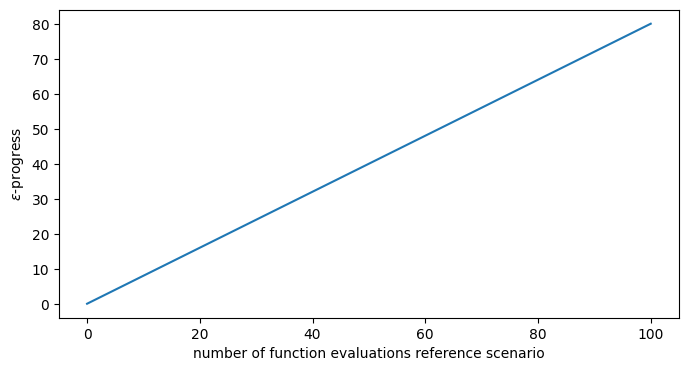

In [12]:
fig, ax = plt.subplots(ncols=1, sharex=True, figsize=(8,4))
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations reference scenario')
plt.savefig('Figures/convergence_ref_scen.PNG')
plt.show

In [14]:
thresholds = results[
                     (results["Expected Number of Deaths other dike rings"] < 0.08) &
                     (results['Evacuation Costs'] < 10000)]

thresholds.loc[:, [o.name for o in dike_model.outcomes]]

KeyError: 'Expected Number of Deaths other dike rings'

In [5]:
good_policies = thresholds.loc[:, [o.name for o in dike_model.outcomes]]
all_policies =  results.loc[:, [o.name for o in dike_model.outcomes]]

# Plot parcoords
limits = parcoords.get_limits(all_policies)
axes = parcoords.ParallelAxes(limits)
axes.plot(all_policies, color='lightgrey', label="Disregarded Cases")
axes.plot(good_policies, color='green', label="Cases of Interest")
axes.legend()
fig = axes.fig
fig.set_size_inches(15,5)
plt.savefig("Figures/parcoords_ref_scen.PNG")
plt.show()

NameError: name 'thresholds' is not defined

In [ ]:
policies = thresholds.drop([o.name for o in dike_model.outcomes], axis=1)
policies

In [ ]:
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))